In [5]:
from torch.utils.data import DataLoader
from torchvision import transforms
import medicalDataLoader
from utils import *
from multi_UNet_complex import *

In [6]:
import torch

# Select GPU if available, else CPU
device = torch.device('cpu')
print(device)

cpu


In [7]:
import warnings
warnings.filterwarnings("ignore")

In [20]:
def lossFunction(loss1,loss2,alpha:float,predictions, y_hat_1, y_hat_2):
    if(alpha>1 or alpha<0):
        Exception("alpha is outside [0;1]")
    _loss1 = loss1(predictions, y_hat_1)
    _loss2 = loss2(predictions, y_hat_2)
    return alpha * _loss1 + (1-alpha) * _loss2

## Supervised


Learning rate using 5 epochs, a batch size of 32 and UNet Complexe

Schedulers :
- `CosineAnnealingLR` ![learning_CosineAnnealingLR.png](./img/learning_CosineAnnealingLR.png)
    - Adoucit progressivement le taux d'apprentissage, aidant potentiellement le modèle à converger plus rapidement.
    - Peut être utile pour les modèles avec des espaces de paramètres étendus.
- `LambdaLR` ![learning_LambdaLR.png](./img/learning_LambdaLR.png)

In [46]:
def runTraining(epoch_num, weights_path='', augm = False):
    print('-' * 40)
    print('~~~~~~~~  Starting the training... ~~~~~~')
    print('-' * 40)

    ## DEFINE HYPERPARAMETERS (batch_size > 1)
    batch_size = 16
    batch_size_val = 16
    lr = 0.001   # Learning Rate
    epoch = epoch_num # Number of epochs

    root_dir = './Data/'

    print(' Dataset: {} '.format(root_dir))

    ## DEFINE THE TRANSFORMATIONS TO DO AND THE VARIABLES FOR TRAINING AND VALIDATION

    transform = transforms.Compose([
        transforms.ToTensor()
    ])

    mask_transform = transforms.Compose([
        transforms.ToTensor()
    ])

    train_set_full = medicalDataLoader.MedicalImageDataset('train',
                                                      root_dir,
                                                      transform=transform,
                                                      mask_transform=mask_transform,
                                                      augment=augm,  # Set to True to enable data augmentation
                                                      equalize=False)

    train_loader_full = DataLoader(train_set_full,
                              batch_size=batch_size,
                              worker_init_fn=np.random.seed(0),
                              num_workers=0,
                              shuffle=True)


    val_set = medicalDataLoader.MedicalImageDataset('val',
                                                    root_dir,
                                                    transform=transform,
                                                    mask_transform=mask_transform,
                                                    equalize=False)

    val_loader = DataLoader(val_set,
                            batch_size=batch_size_val,
                            worker_init_fn=np.random.seed(0),
                            num_workers=0,
                            shuffle=False)


    ## INITIALIZE YOUR MODEL
    num_classes = 4 # NUMBER OF CLASSES

    print("~~~~~~~~~~~ Creating the UNet model ~~~~~~~~~~")
    modelName = 'Test_Model'
    print(" Model Name: {}".format(modelName))

    ## CREATION OF YOUR MODEL
    net = ComplexUNet(num_classes)

    #net = UNet(num_classes)
    net = net.to(device)  # Move the model to the device

    ## Load the weights from the previously trained model
    if weights_path != '':
        # previous_model_dir = './models/' + 'Test_Model' + '/' + str(epoch_num) +'_Epoch'
        net.load_state_dict(torch.load(weights_path))
        print(" Model loaded: {}".format(weights_path))

    print("Total params: {0:,}".format(sum(p.numel() for p in net.parameters() if p.requires_grad)))

    # DEFINE YOUR OUTPUT COMPONENTS (e.g., SOFTMAX, LOSS FUNCTION, ETC)
    softMax = torch.nn.Softmax(dim=1)
    CE_loss = torch.nn.CrossEntropyLoss()
    DiceLossV2Train = DiceLossV2(n_classes=4)

    ## PUT EVERYTHING IN GPU RESOURCES
    if torch.cuda.is_available():
        net.cuda()
        softMax.cuda()
        CE_loss.cuda()

    ## DEFINE YOUR OPTIMIZER
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    lambda1 = lambda epoch: 0.95 ** epoch
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)


    ### To save statistics ####
    lossTotalTraining = []
    lossTotalVal = []
    Best_loss_val = 1000
    BestEpoch = 0
    lrs = []
    patience = 3

    directory = 'Results/Statistics/' + modelName

    print("~~~~~~~~~~~ Starting the training ~~~~~~~~~~")
    if os.path.exists(directory)==False:
        os.makedirs(directory)

    ## START THE TRAINING

    ## FOR EACH EPOCH
    for i in range(epoch):
        net.train()
        lossEpoch = []
        lrEpoch = []
        num_batches = len(train_loader_full)

        ## FOR EACH BATCH
        for j, data in enumerate(train_loader_full):
            ### Set to zero all the gradients
            net.zero_grad()
            optimizer.zero_grad()

            ## GET IMAGES, LABELS and IMG NAMES
            images = data[0]
            labels = data[1]
            # img_names = data[2]

            ### From numpy to torch variables
            labels = to_var(labels)
            images = to_var(images)

            ################### Train ###################
            #-- The CNN makes its predictions (forward pass)
            net_predictions = net.forward(images)
            s_pred = softMax(net_predictions)
            #-- Compute the losses --#
            # THIS FUNCTION IS TO CONVERT LABELS TO A FORMAT TO BE USED IN THIS CODE

            segmentation_classes = getTargetSegmentation(labels)
            seg_one_hot = F.one_hot(segmentation_classes ,num_classes=4).permute(0, 3, 1, 2).float()

            # COMPUTE THE LOSS
            #pred_one = predToSegmentation(s_pred)
            #CE_loss_value = 0.4 * CE_loss(net_predictions, seg_one_hot) + 0.6 * DiceLossV2Train(net_predictions ,segmentation_classes, softmax=True)# XXXXXX and YYYYYYY are your inputs for the CE
            loss = lossFunction(CE_loss,DiceLossV2Train,0.4,s_pred,seg_one_hot,segmentation_classes)

            lossTotal = loss
            # DO THE STEPS FOR BACKPROP (two things to be done in pytorch)
            loss.backward()
            optimizer.step()


            # Update LR
            #scheduler.step()
            lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
            lrEpoch.append(lr_step)

            # THIS IS JUST TO VISUALIZE THE TRAINING
            lossEpoch.append(lossTotal.cpu().data.numpy())

            #scheduler.step()
            printProgressBar(j + 1, num_batches,
                             prefix="[Training] Epoch: {} ".format(i),
                             length=15,
                             suffix=" Loss: {:.4f}, lr: {} ".format(lossTotal,lr_step))

        lossEpoch = np.asarray(lossEpoch)
        lossEpoch = lossEpoch.mean()

        lossVal = inference(net, val_loader, "modele", i)
        scheduler.step()
        lossTotalVal.append(lossVal)
        lossTotalTraining.append(lossEpoch)

        lrEpoch = np.asarray(lrEpoch)
        lrEpoch = lrEpoch.mean()
        lrs.append(lrEpoch)

        printProgressBar(num_batches, num_batches,
                             done="[Training] Epoch: {}, LossT: {:.4f}, LossV: {:.4f}".format(i, lossEpoch, lossVal))

        if not os.path.exists('./models/' + modelName):
                os.makedirs('./models/' + modelName)

        if lossVal > Best_loss_val:
                trigger_times += 1
                print('trigger times:', trigger_times)


                if trigger_times >= patience:
                    print('Early stopping!\nStart to test process.')
                    torch.save(net.state_dict(), './models/' + modelName + '/' + str(i) + '_Epoch')
                    break
        else:
            print('trigger times: 0')
            trigger_times = 0
        torch.save(net.state_dict(), './models/' + modelName + '/' + str(i) + '_Epoch')
        Best_loss_val = lossVal
    return lossTotalTraining, lossTotalVal, batch_size, batch_size_val, lrs, lr


In [47]:
lossTotalTraining, lossTotalVal, batch_size, batch_size_val, lrs, lr = runTraining(5)

----------------------------------------
~~~~~~~~  Starting the training... ~~~~~~
----------------------------------------
 Dataset: ./Data/ 
~~~~~~~~~~~ Creating the UNet model ~~~~~~~~~~
 Model Name: Test_Model
Total params: 7,068,708
~~~~~~~~~~~ Starting the training ~~~~~~~~~~
[Training] Epoch: 0 [DONE]                                           
[Inference] Segmentation Done !                                                                              
[Training] Epoch: 0, LossT: 1.0452, LossV: 18.5068                                                           
trigger times: 0
[Training] Epoch: 1 [DONE]                                             
[Inference] Segmentation Done !                                                                              
[Training] Epoch: 1, LossT: 0.9643, LossV: 6.3029                                                            
trigger times: 0
[Training] Epoch: 2 [DONE]                                               
[Inference] Segmentation Do

In [29]:
print(f"Losses Training : {lossTotalTraining}")
print(f"Losses Validation : {lossTotalVal}")

Losses Training : [1.0206486, 0.9350837, 0.85337555, 0.7754875, 0.6955475]
Losses Validation : [11.214131, 2.284823, 0.9428118, 0.64575756, 0.46052247]


In [48]:
import matplotlib.pyplot as plt

def get_Training_learning(training_loss,validation_loss, learning_rate, all_learning_rate,
                          training_batch_size,validation_batch_size,opt_name = "Adam"):

    # validation_loss.pop(0)
    # training_loss.pop(0)
    files = os.listdir('./models/Test_Model')

    epochs = range(len(files))

    plt.figure(figsize=(12, 6))
    plt.plot(epochs, training_loss, 'r', label='Training loss')
    plt.plot(epochs, validation_loss, 'b', label='Validation loss')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    info_text = (
        f"Learning Rate: {learning_rate:.5f}\n"
        f"All Learning Rates: {', '.join(map(str, all_learning_rate))}\n"
        f"Training Batch Size: {training_batch_size}\n"
        f"Validation Batch Size: {validation_batch_size}\n"
        f"Optimizer: {opt_name}"
    )

    plt.annotate(info_text, xy=(0.02, 0.92), xycoords='axes fraction', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor="white", facecolor="white"))

    plt.savefig("./Results/learning.png")
    plt.show()

In [49]:
type(lossTotalVal)

list

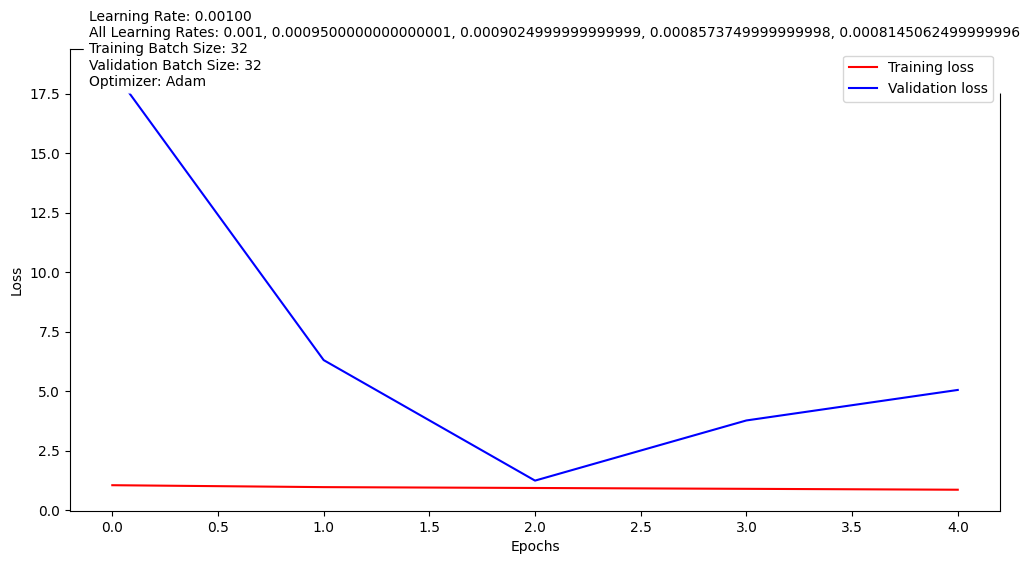

In [50]:
get_Training_learning(lossTotalTraining,lossTotalVal, lr, lrs, batch_size,batch_size_val,opt_name = "Adam")

In [12]:
# Testing the model on an Image

from PIL import Image
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt


def plotOutput(model_path, image_path):

    ## CREATION OF YOUR MODEL
    net_test = ComplexUNet(4)
    net_test = net_test.to(device)
    net_test.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    # Load the image
    image = Image.open(image_path)

    # Convert the image to grayscale
    if image.mode != 'L':
        image = image.convert('L')

    # Preprocess the image
    x = TF.to_tensor(image)
    x = TF.normalize(x, [0.5], [0.5])
    x = x.unsqueeze(0)  # Add batch dimension

    # Move the tensor to the same device as the model
    x = x.to(device)

    output = net_test(x)

    # The output is the predicted segmentation
    predicted_segmentation = torch.argmax(output.squeeze(), dim=0)

    # Convert the tensor to a numpy array
    predicted_segmentation = predicted_segmentation.detach().cpu().numpy()

    # Display the predicted segmentation
    plt.imshow(predicted_segmentation, cmap='gray')
    plt.show()

In [14]:
# Displaying the outputs for different models

models_paths = ['./models/' + 'Trained/2nd_model_simple_multi_unet_model/Data_Augmented/Augmented_' + str(i) + 'x' for i in range(6)]
import torch

image_path = "./Data/val/Img/patient001_12_2.png"
#plotOutput('./models/' + 'Test_Model1/19_Epoch', image_path)
plotOutput('./models/' + 'Test_Model/9evalStagne_Epoch', image_path)
#plotOutput('./models/' + 'Trained/2nd_model_simple_multi_unet_model/Data_Augmented/Augmented_5x', image_path)


FileNotFoundError: [Errno 2] No such file or directory: './models/Test_Model/9evalStagne_Epoch'